# Instantiate project environment

In [19]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `c:\Users\nicol\GitHub\YardSale\tutorials`


# Import necessary packages

In [20]:
using YardSale
using Plots, Measures, LaTeXStrings, ColorSchemes

# Description of the notebook
In this notebook we'll explore the behavior of the Extended Yard-Sale Model (EYSM), simulating the (stochastic) evolution of an economical systems of $N$ agents. These agents are characterized by their wealth $w_i, \;i=1,...,N$. The rules of the model have been described in the `ode_systems.ipynb` notebook. 
Here, we add the stochasticity to the model, in the framework of Monte Carlo simulations. With this addition, we expect to see not only the phase transition of the model, but also the fluctuations around the critical point. 

Remember that the exchange rule of the EYSM is given by:
$$
\Delta w_{ij} = \chi \Delta t \bigg(\frac{W}{N} - w_i\bigg) + \eta_{ij} \sqrt{\gamma \Delta t} \min(w_i,w_j),
$$
where $\chi$ is the redistribution rate, $\sqrt{\gamma \Delta t}$ represents the fraction $f$ of the wealth that is exchanged between agents $i$ and $j$ at each time step, and $\eta_{ij}$ is a random number that can be $\pm 1$. This stochastic variable has the properties
$$
\langle \eta_{ij} \rangle = \zeta N \sqrt{\frac{\Delta t}{\gamma}} \frac{(w_i - w_j)}{W}, \qquad \langle \eta_{ij}^2 \rangle = 1.
$$
The parameter $\zeta$ represents the Wealth-Attained Advantage (WAA) parameter, which is a bias that favors the richer agent in the exchange.
Finally, the wealth of the agents is updated as
$$
w_i \to w_i + \Delta w_{ij}, \qquad w_j \to w_j - \Delta w_{ij}.
$$

In this notebook, we''ll explore the behavior of the EYSM model using Monte Carlo simulations. We''ll study the dynamics and the phase transition of the model measuring the order parameter and its fluctuations at the steady state.

# Time evolution of the wealth distribution
For a small system, we can visualize the evolution of the wealth of each agent over time.

In [21]:
# Parameters of the system
N = 16
W_N = 1.0

# Temperature of the system: χ/ζ
chi = 1.0
zeta = 1.0

# The fraction of exchange determines in some way the intensity of the noise,
# Larger values of f will speed up the system, but it will also make the noise
# more intense, an the dynamics will be less smooth. 
# I found that f < 0.1 is a rule of thumb.
f = 0.01

# Steps to run the simulation
steps = 10000 # MC steps
# Seed
seed = 42 # The answer to the ultimate question of life, the universe and everything

# Optional
save_every = 1 
;

In [22]:
# Run 
@time w_t = EYSM_base_full(N, W_N, chi, zeta, f, steps, seed; save_every=save_every)

# Sort the columns according to the final state
w_t = w_t[:,sortperm(w_t[end,:])]

  0.013366 seconds (350.02 k allocations: 14.344 MiB)


10001×16 Matrix{Float64}:
 1.0       1.0       1.0       1.0       …  1.0       1.0       1.0
 1.00988   1.00011   0.990101  1.01         0.990199  1.0       1.01979
 1.00988   0.999997  0.970359  0.989991     0.990195  0.999996  1.02948
 1.02985   0.980294  0.980077  0.999894     0.970505  0.989931  1.04963
 1.01964   0.970732  0.979959  0.999896     0.970441  0.989934  1.04964
 1.00953   1.00018   0.979958  1.02938   …  0.960755  0.999838  1.02978
 0.999528  0.981201  0.989694  1.02911      0.97039   1.01993   1.02015
 0.999133  0.971524  1.00831   1.02907      0.960703  1.0204    1.02003
 0.989324  0.99047   0.998984  1.03846      0.97033   1.03038   1.03996
 0.979914  0.990466  0.998689  1.02873      0.950995  1.04025   1.03979
 0.969973  0.990473  0.979881  1.01851   …  0.950961  1.0313    1.03885
 0.970002  0.98056   0.960972  1.00877      0.970246  1.04145   1.02892
 0.969923  0.970407  0.98012   1.00876      0.970233  1.07141   1.01859
 ⋮                                       ⋱

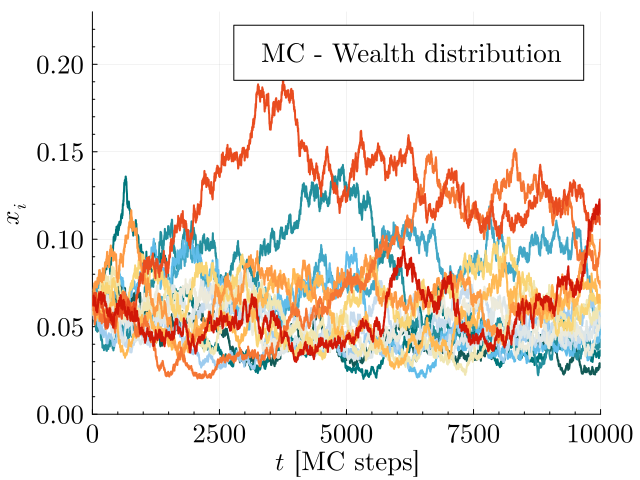

In [23]:
p1 = plot(
    ylabel = L"x_i",
    xlabel = L"t"*" [MC steps]",
    fontfamily = "Computer Modern",
    legend_title = "MC - Wealth distribution",
    xguidefontsize = 17,
    yguidefontsize = 17,
    legendfontsize = 15,
    legendtitlefontsize = 17,
    xtickfontsize = 17,
    ytickfontsize = 17,
    palette = :tol_nightfall,
    size=(640,480),
    fmt=:png,
    ylims = (0, 0.23),
    xlims = (0,:auto),
    minorticks = true,
    right_margin = 8mm,
    legend = :topright,
)    

for i in 1:N
    plot!(p1,w_t[:,i]/N, label = "", lw = 2)
end

display(p1)

# 2. Phase transition properties

Now, we would like to study the phase transition of the model. For that, we need to make some statistics over a certain number of realizations of the model. Then we can calculate the order parameter and its fluctuations.
In Julia, we can use the `Threads.@threads` macro to parallelize the independent simulations. This will speed up the calculations. Then the order parameter and its fluctuations can be calculated with the `Statistics.jl` package.

In [24]:
using ProgressMeter

In [25]:
# Number of runs
N = 64
W_N = 1.0f0
zeta = 1.0f0
chi = 0.0f0:0.04f0:2.0f0
steps = 30000 * N # MC steps: 30000 * 128 = 3.84e6
seed = 42
# Run
sims = zeros(typeof(W_N), length(chi), (steps ÷ N) + 1, N)

# Safe lock 
lk = ReentrantLock()
# ProgressMeter
p = Progress(length(chi), showspeed=true)
Threads.@threads for i in 1:length(chi)
    w_t = EYSM_base_full(N, W_N, chi[i], zeta, f, steps, seed)
    lock(lk) do 
        sims[i,:,:] = w_t
        next!(p)
    end
end

Progress: 100%|███████████████████████████| Time: 0:03:32 ( 4.17  s/it)


In [27]:
x1 = get_x1(sims,3)

LoadError: MethodError: no method matching get_x1(::Array{Float32, 3}, ::Int64)
The function `get_x1` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  get_x1([91m::AbstractMatrix[39m, ::Union{Integer, Tuple{Integer, Integer}})
[0m[90m   @[39m [36mYardSale[39m [90mC:\Users\nicol\.julia\packages\YardSale\eKOvx\src\data_analysis\[39m[90m[4mmc_analysis_functions.jl:13[24m[39m
[0m  get_x1([91m::AbstractMatrix[39m)
[0m[90m   @[39m [36mYardSale[39m [90mC:\Users\nicol\.julia\packages\YardSale\eKOvx\src\data_analysis\[39m[90m[4mmc_analysis_functions.jl:13[24m[39m
